*I used the Gemini 2.5 flash for some of the visualizations and the assumptions for GAM. I referred to the XAI repo and the internet for some of these questions.*

This is the link:
https://colab.research.google.com/drive/1oPpi81oGGa6bS4fag5afnfY1ufbvv81t#scrollTo=b0EcfaTeb-JC

## 1.

Exploratory Data Analysis to check Assumptions: Perform an exploratory analysis of the dataset to understand the relationships between different features and the target variable (churn).

Use appropriate visualizations and statistical methods to determine whether assumptions about linear, logistic, and GAM models are met.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
def understand_df(df):
    # Set pandas display options to show all columns
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)


    # Dimensions of dataset
    print("Dimension of the dataset is", df.shape, "\n\n")

    # Head of dataset
    print("First 5 rows of the dataset are \n", df.head(), "\n\n")

    # Summary of dataset
    print("Summary of the dataset is \n", df.describe(), "\n\n")

    # Columns of dataset
    print("The information of the dataset is as follows\n", df.info(), "\n\n")

    # Stats of dataset
    stats = []

    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    print(f"Statistics of the dataset are \n {stats_df.sort_values('Percentage of missing values', ascending=False)}\n\n")

In [4]:
understand_df(df)

Dimension of the dataset is (7043, 21) 


First 5 rows of the dataset are 
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport Streaming

In [5]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype(int)

In [6]:
def discover_categorical_and_numerical(df):
  # type_dictionary = {col: ("categorical" if df[col].dtype == "O" else "numerical") for col in df.columns}
  # categorical = [key for key, val in type_dictionary.items() if val == "categorical"]

  categorical = df.select_dtypes(include=object).columns.to_list() # [c in df.columns if df[c].dtype == "O"]
  numerical = df.select_dtypes(include=np.number).columns.to_list() # df.columns.difference(categorical)

  """
  To select datetimes, use np.datetime64, 'datetime' or 'datetime64'
  To select timedeltas, use np.timedelta64, 'timedelta' or 'timedelta64'
  To select Pandas categorical dtypes, use 'category'
  """

  # make a list of discrete variables
  discrete = [var for var in numerical if len(df[var].unique()) < 20]

  # categorical encoders work only with object type variables to treat numerical variables as categorical, we need to re-cast them
  df[discrete]= df[discrete].astype('O')

  # update numerical variables as continuous variables
  numerical = [var for var in numerical if var not in discrete]

  print(f"There are {len(categorical)} categorical, {len(discrete)} discrete numerical, and {len(numerical)} continuous numerical variables / features in the dataset")
  return categorical, discrete, numerical

In [7]:
obj, disc, num = discover_categorical_and_numerical(df)
print(obj, disc, num)

There are 18 categorical, 1 discrete numerical, and 2 continuous numerical variables / features in the dataset
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn'] ['SeniorCitizen'] ['tenure', 'MonthlyCharges']


In [8]:
df["Churn"].value_counts()

,count
Churn,
No,5174
Yes,1869


In [9]:
def mapping(df, cols):
  for c in cols:
    # 1. lowercase all the strings
    df[c] = df[c].astype(str).str.lower()
    # 2. strip away trailing whitespaces
    df[c] = df[c].str.strip()
    # 3. map "yes" to 1 and "no" to 0, including strings starting with "no"
    df[c] = df[c].apply(lambda x: 1 if x == "yes" else (0 if x.startswith("no") else x))
  return df

In [10]:
df = mapping(df, ["Partner", "Dependents", "PhoneService", "OnlineSecurity", "OnlineBackup", "MultipleLines",
                  "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling",
                  "Churn"])

In [11]:
df['MultipleLines'].value_counts()

,count
MultipleLines,
0,4072
1,2971


#### checking for Linear Regression Assumptions

Linearity

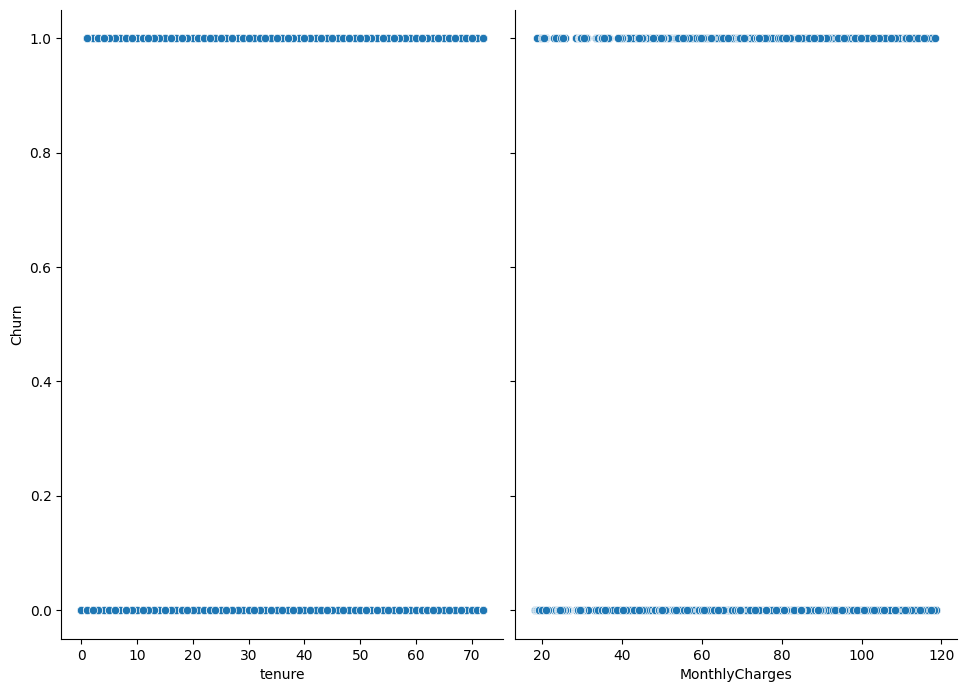

In [12]:
p = sns.pairplot(df, x_vars=num, y_vars="Churn", height=7, aspect=0.7)

The relationship between the models are not really linear. There is a clear "z" shape which would make sense for logistic regression.

In [13]:
from scipy.stats import pearsonr as pcr

def plot_correlation_matrix(df, independent, numerical):
    # Compute the correlation matrix
    corr = df[numerical].corr().round(1) #

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(30, 30))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()

    # correlation with the independent variable
    correlations = {n: pcr(df[n], df[independent]).statistic for n in numerical}
    correlations = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
    correlations = correlations.sort_values('Correlation', ascending=False).style.background_gradient()

    # weak_corr = correlations[(np.abs(correlations["Correlation"])) < 0.5]
    return correlations

In [14]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Fill Na for 'TotalCharges' with the median value
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
# Explicitly convert to float to ensure the correct dtype
df['TotalCharges'] = df['TotalCharges'].astype(float)

/tmp/ipython-input-3613227133.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [15]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [16]:
num = ['tenure', 'MonthlyCharges', 'TotalCharges']
disc = ["Partner", "Dependents", "PhoneService", "OnlineSecurity", "OnlineBackup", "MultipleLines",
        "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "SeniorCitizen"]
obj = ["gender", "InternetService", "Contract", "PaymentMethod"]
# customer ID is omitted.

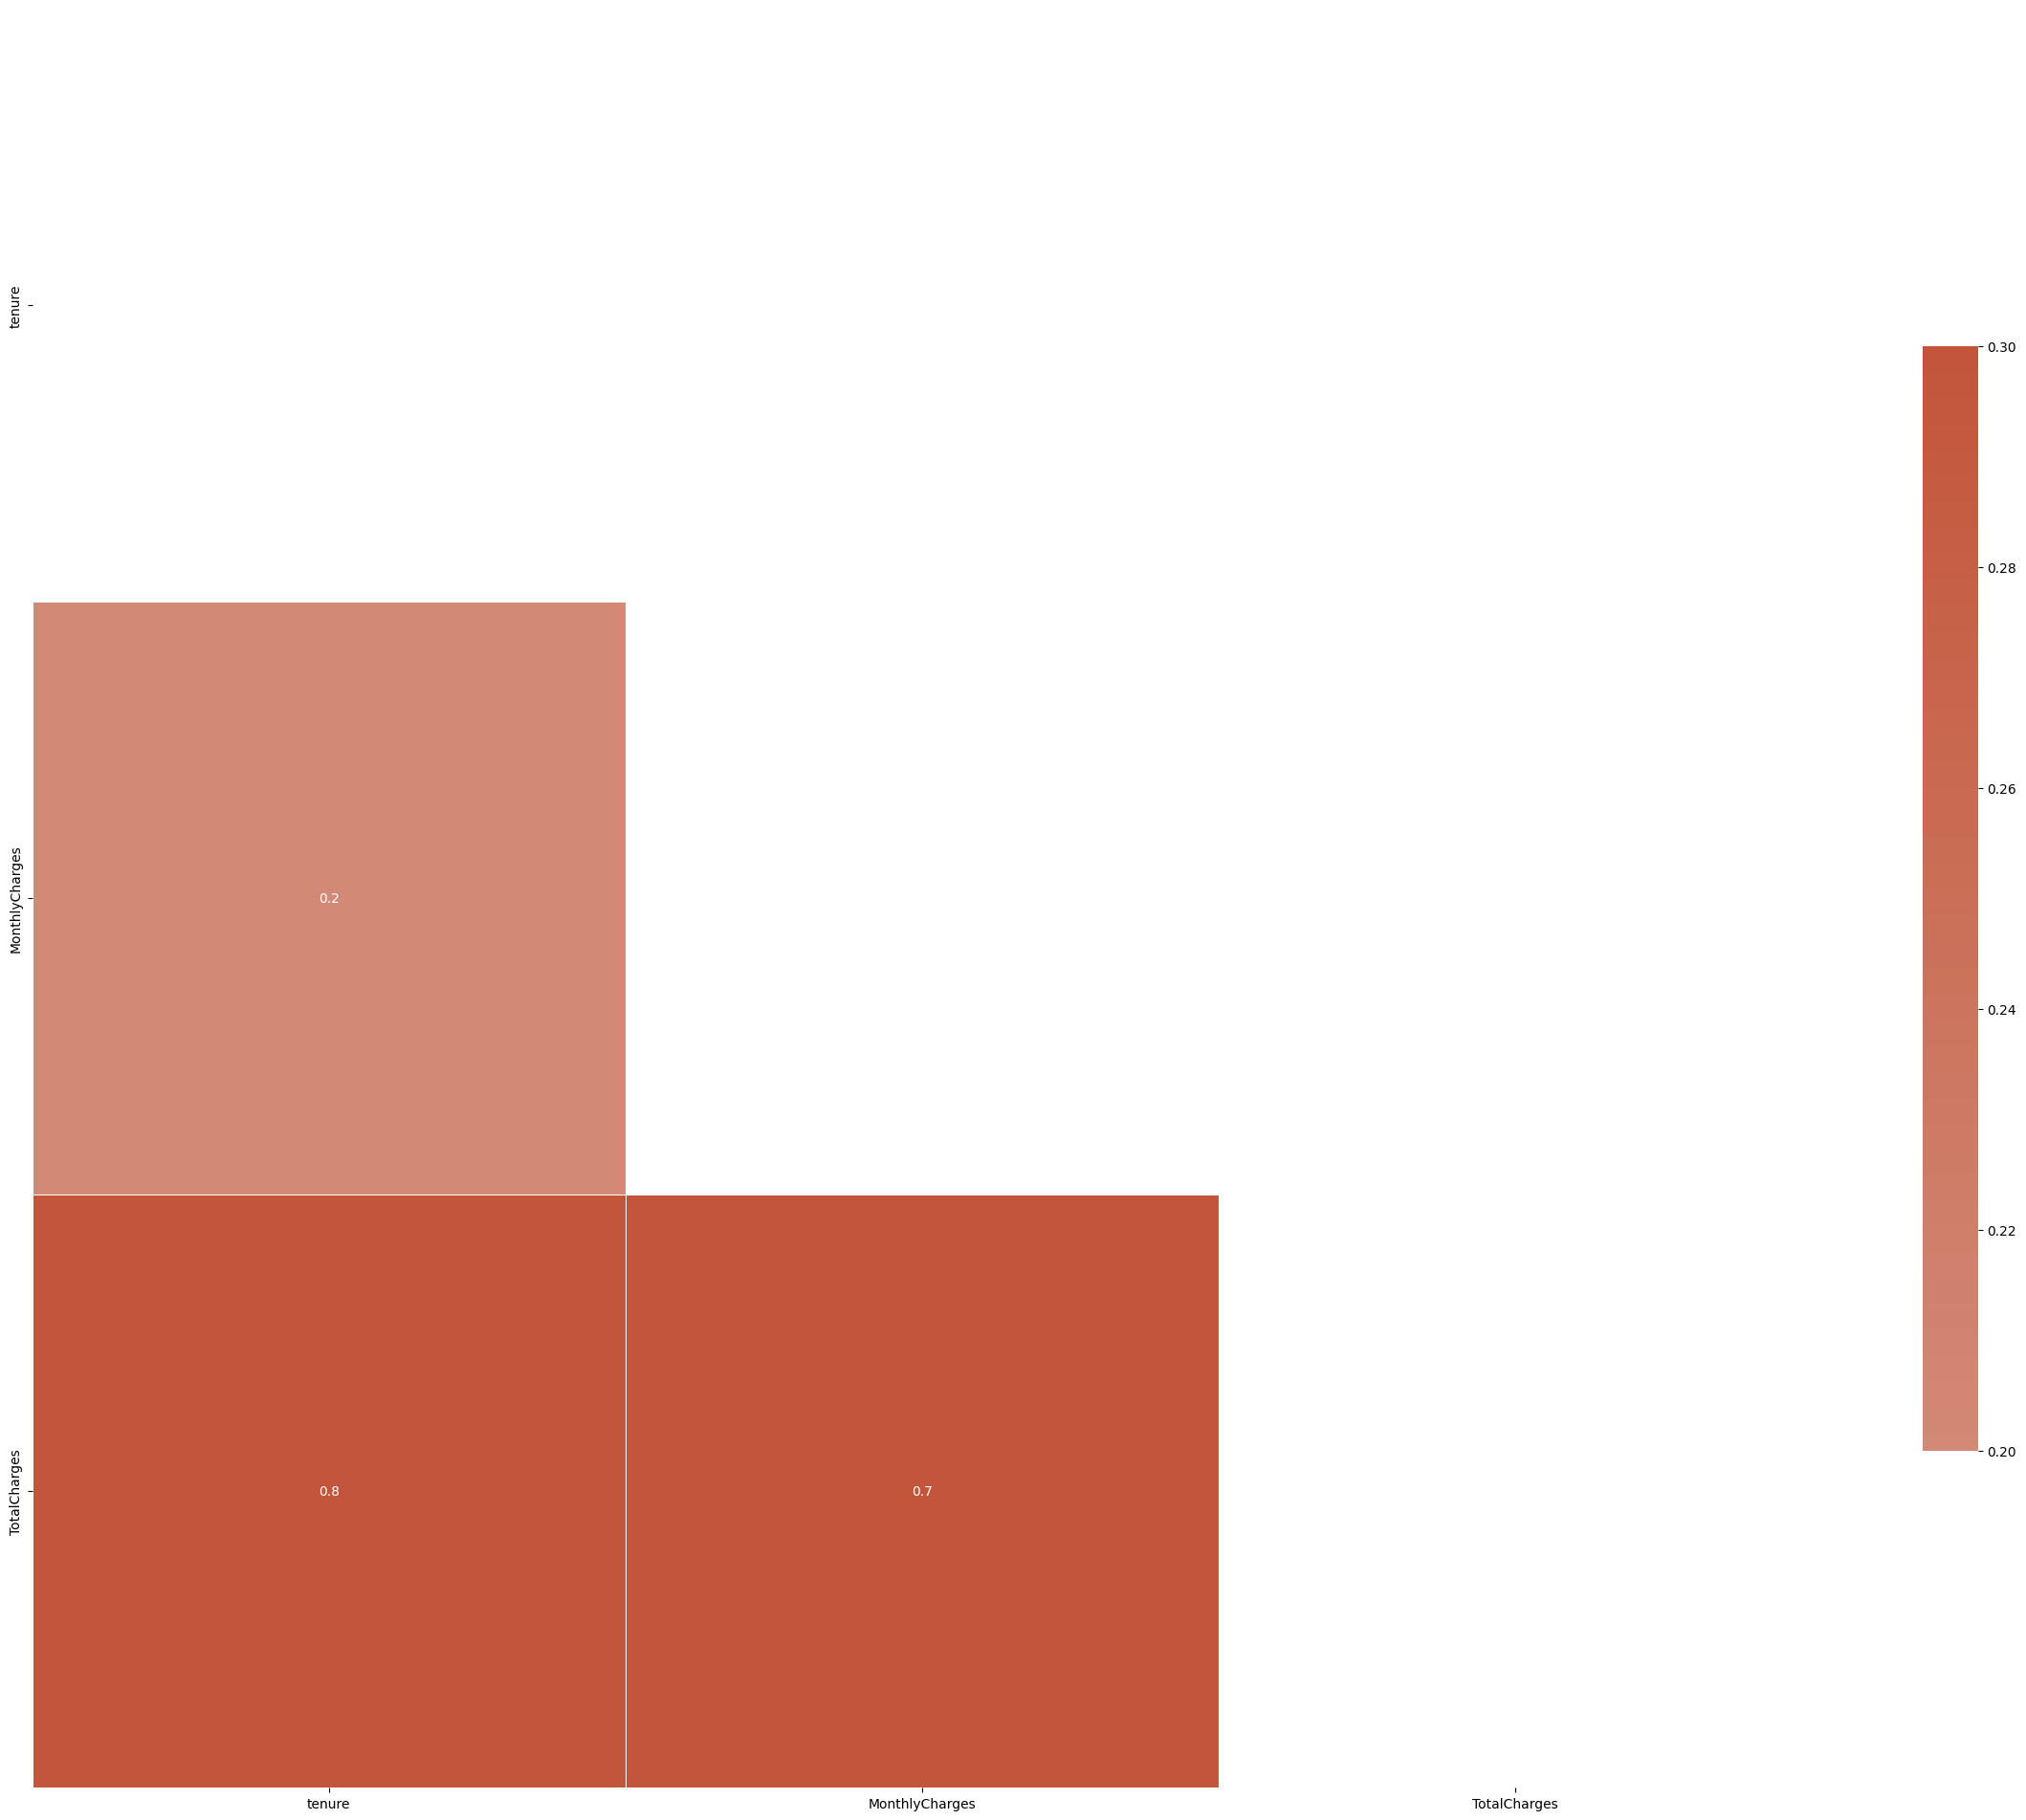

,Feature,Correlation
1,MonthlyCharges,0.193356
2,TotalCharges,-0.199037
0,tenure,-0.352229


In [17]:
# Include 'TotalCharges' in the numerical columns for correlation plot
plot_correlation_matrix(df, "Churn", num)

There is some strong multicollinearity going on within the predictor variables (at least the numerical ones). The linear regression assumption may not be met here.

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model


x = df[num]
y = df["Churn"]

sc = StandardScaler()
X = sc.fit_transform(x)

regr = linear_model.LinearRegression()
regr.fit(X, y)
y_pred = regr.predict(X)

resid = y_pred - y

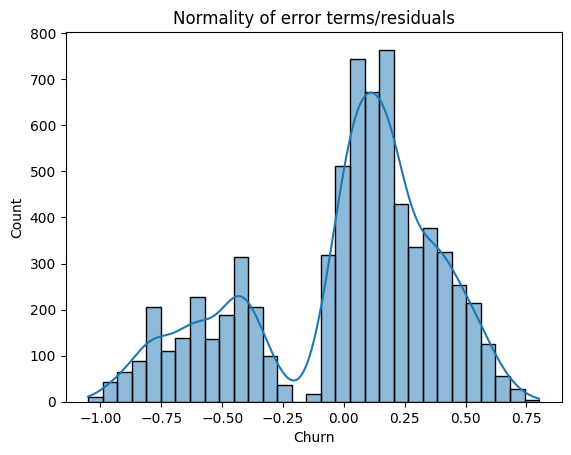

In [19]:
p = sns.histplot(resid, kde=True)
p = plt.title('Normality of error terms/residuals')

Apparently this is not normally distributed. I would say that the linear regression model would not work here.

#### checking for logistic regression assumptions

1. binary dependent variable

In [20]:
df["Churn"].value_counts()

,count
Churn,
0,5174
1,1869


Surely, the churn column has 2 outcomes, clearly binary.

2. No Multicollinearity

As seen above, there is multicollinearity among the numeric variables.

3. The Observations are Independent

Assuming that each customer in the dataset is not connected to others and/or the sampling method does not create dependencies among the customers, this can be satisfied.

4. There are No Extreme Outliers

In [21]:
def detect_outliers(df, numerical):
    for c in numerical:
        # Calculate Q1 and Q3
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        # Calculate Interquartile Range (IQR)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        sns.boxplot(df, x=c)
        ax = sns.boxplot(y=c, data=df)
        plt.axhline(y=lower_bound, color='purple', linestyle='--', label='Lower Bound')
        plt.axhline(y=upper_bound, color='purple', linestyle='--', label='Upper Bound')
        plt.legend()
        plt.show()

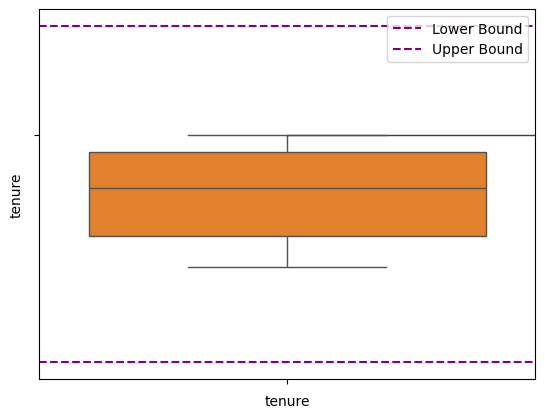

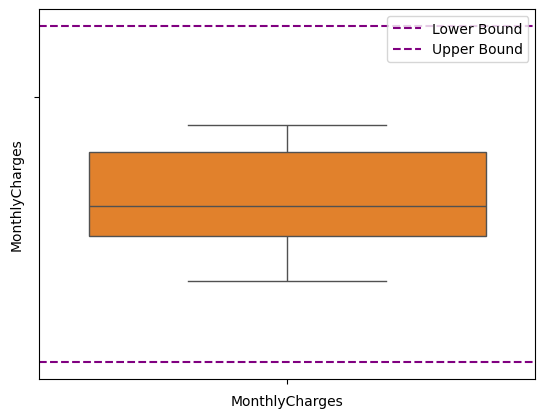

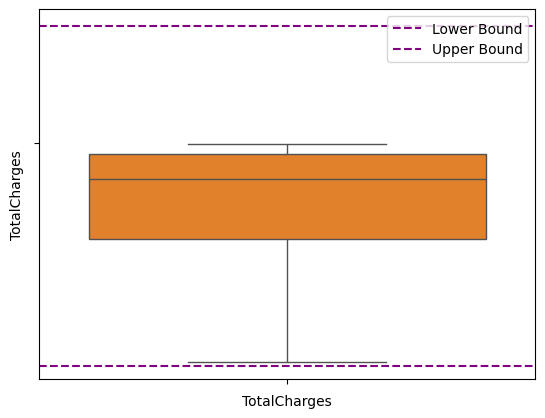

In [22]:
detect_outliers(df, num)

Looks like there aren't critical outliers. Assumption passed.

#### 5. Linear Relationship Between Explanatory Variables and the Logit of the Response Variable


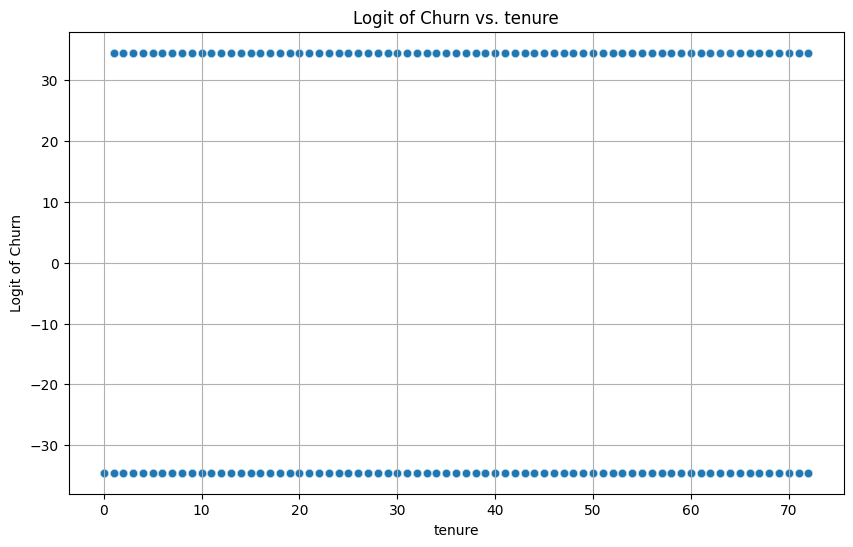

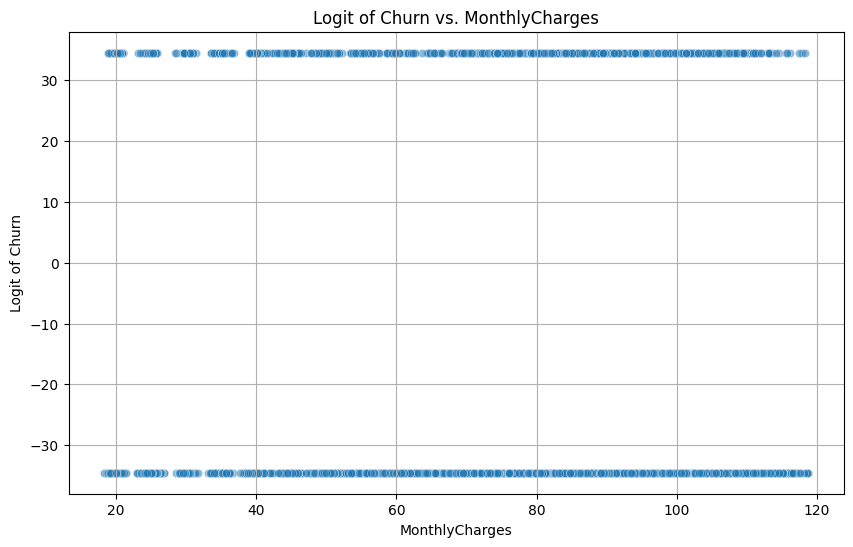

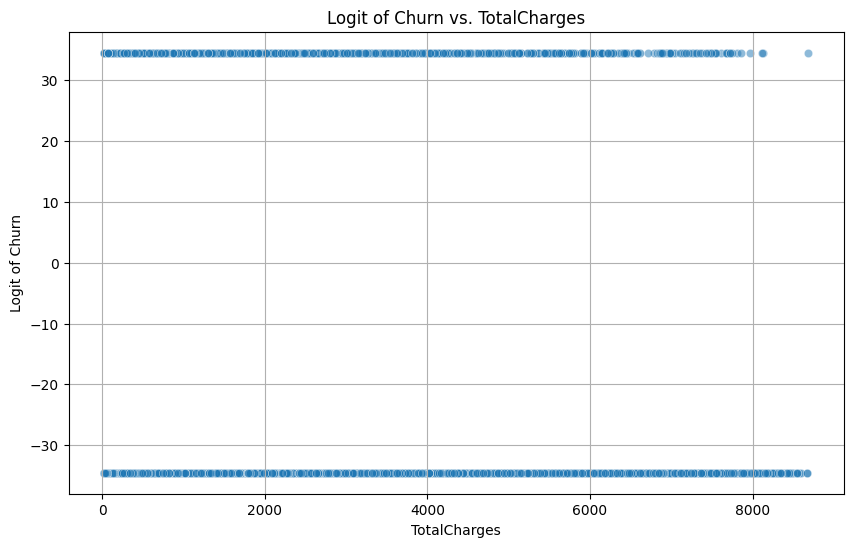

In [23]:
# Calculate the probability of Churn
churn_probability = df["Churn"].astype(float)

# Calculate the logit of Churn probability, handling potential 0 or 1 values by clipping
logit = np.log(churn_probability.clip(1e-15, 1 - 1e-15) / (1 - churn_probability.clip(1e-15, 1 - 1e-15)))

# Plot the relationship between continuous numerical variables and the logit of Churn
for col in num:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[col], y=logit, alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("Logit of Churn")
    plt.title(f"Logit of Churn vs. {col}")
    plt.grid(True)
    plt.show()

All the dots exhibit a dual-line here (likely due to the binary nature of churn). There is a possible violation. But, logistic regression should be a suitable algorithm based on all observations so far.

#### Test the assumptions for the GAM model.

In [28]:
y = df['Churn'].astype(int)

all_features = [col for col in df.columns if col not in ['customerID', 'Churn']]
X = df[all_features].copy()

X_obj = X.select_dtypes(include='object').columns.tolist()
X_disc = [col for col in disc if col in X.columns]
X_num = [col for col in num if col in X.columns]

cols_to_encode = X_obj + X_disc
X_encoded = pd.get_dummies(X, columns=cols_to_encode, drop_first=True)

numerical_cols_encoded = X_num

scaler = StandardScaler()
X_encoded[numerical_cols_encoded] = scaler.fit_transform(X_encoded[numerical_cols_encoded])

In [30]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.9 MB/s eta 0:00:00


In [32]:
from pygam import LinearGAM

gam = LinearGAM()
gam.fit(X_encoded, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + intercept,
   tol=0.0001, verbose=False)

1. Check linearity

Examine the relationships between the independent variables and the dependent variable to check for linearity.


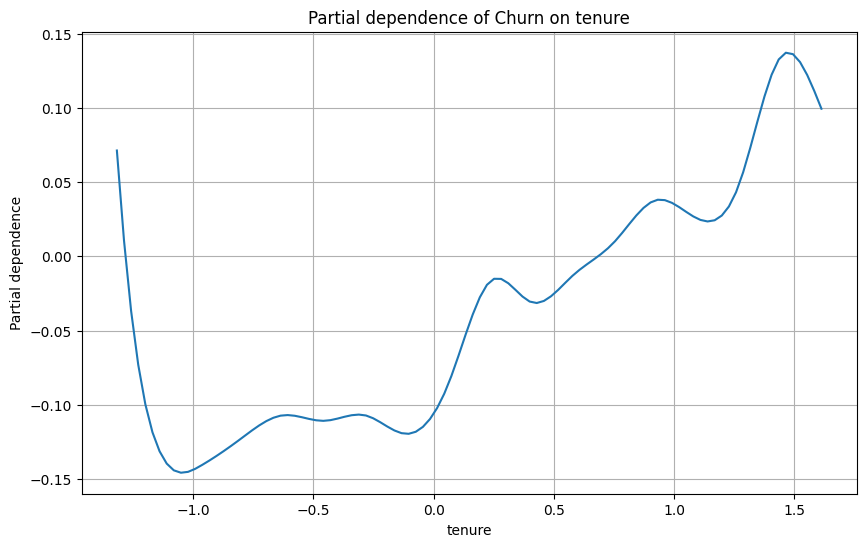

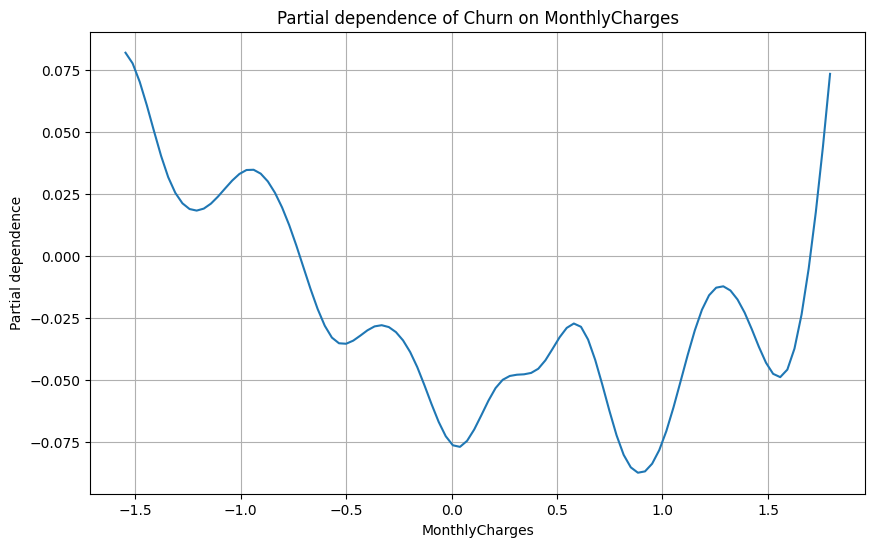

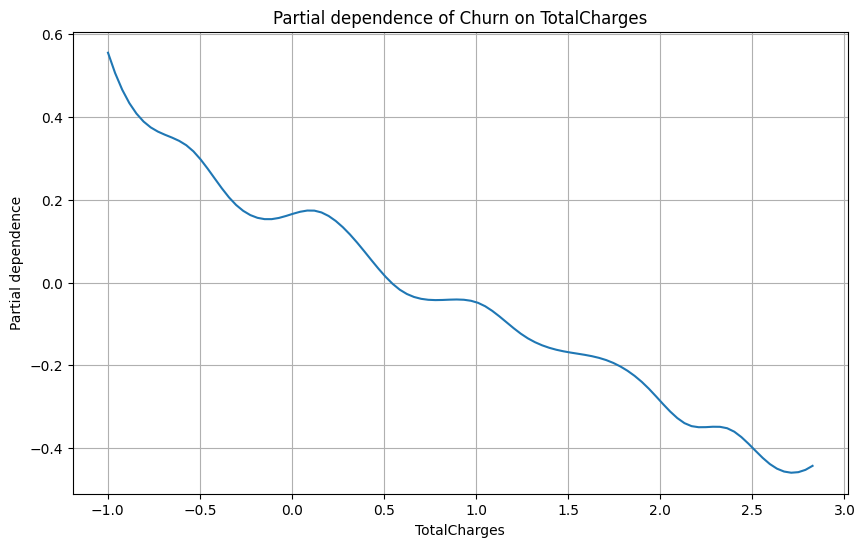

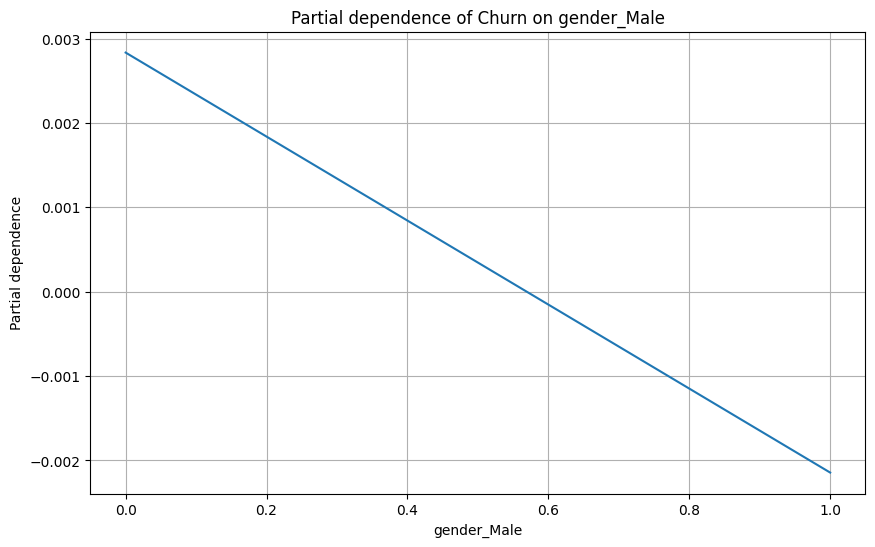

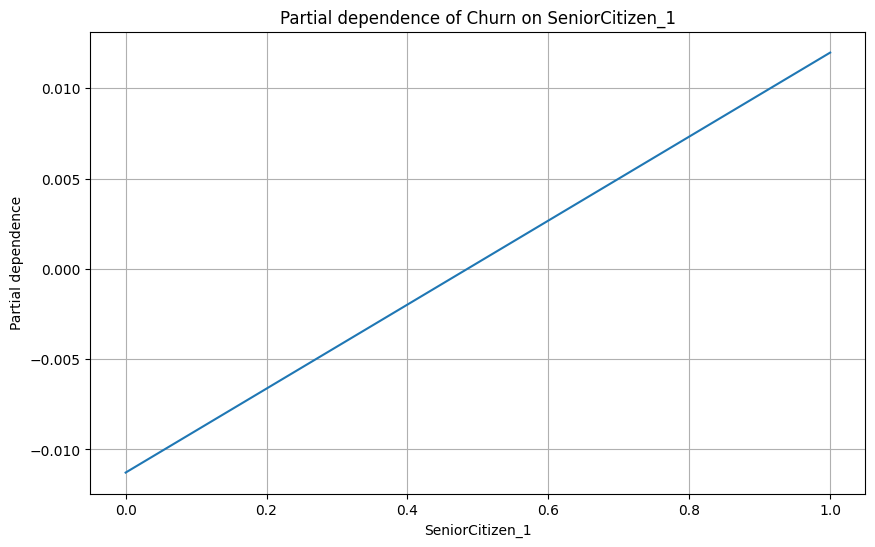

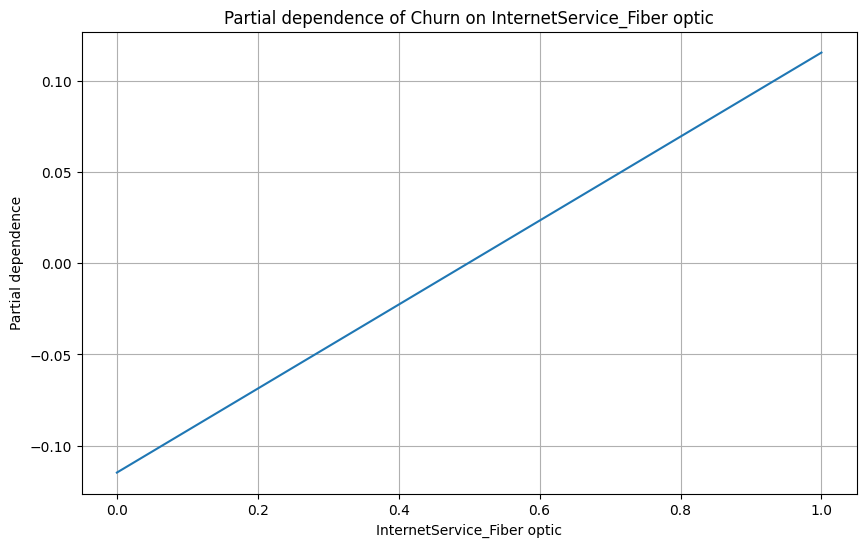

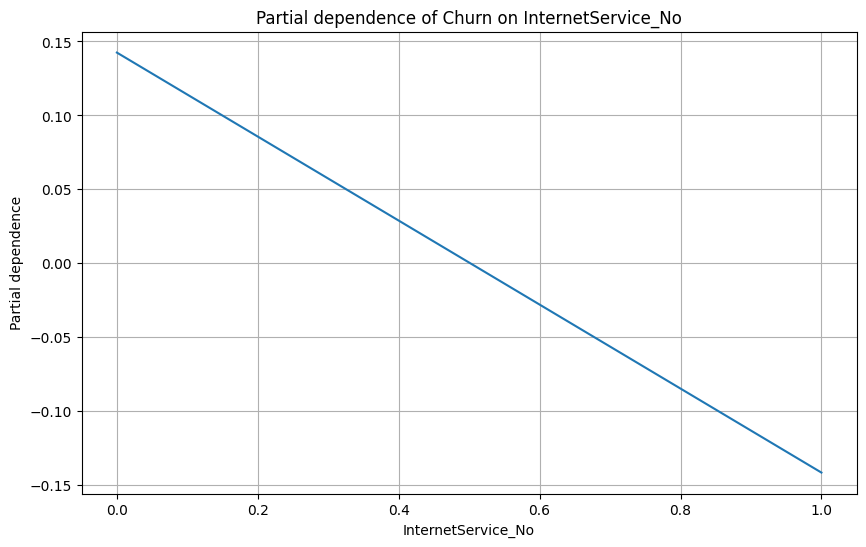

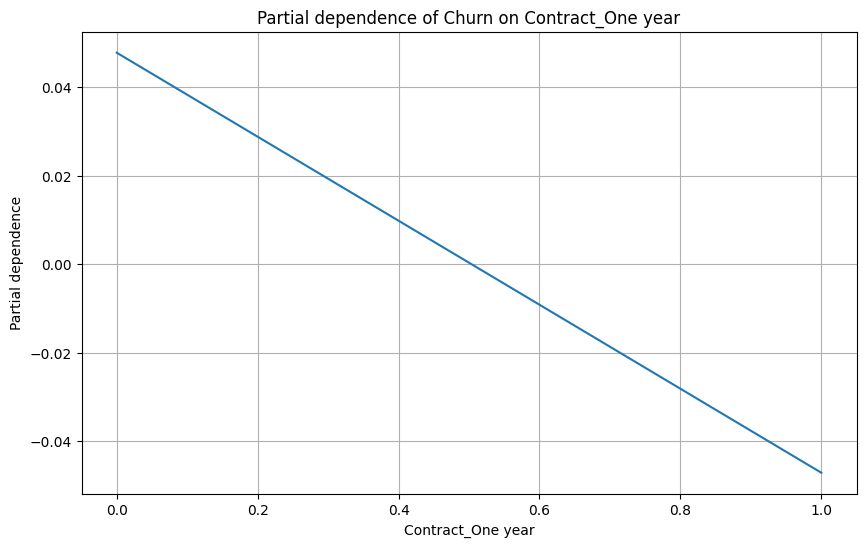

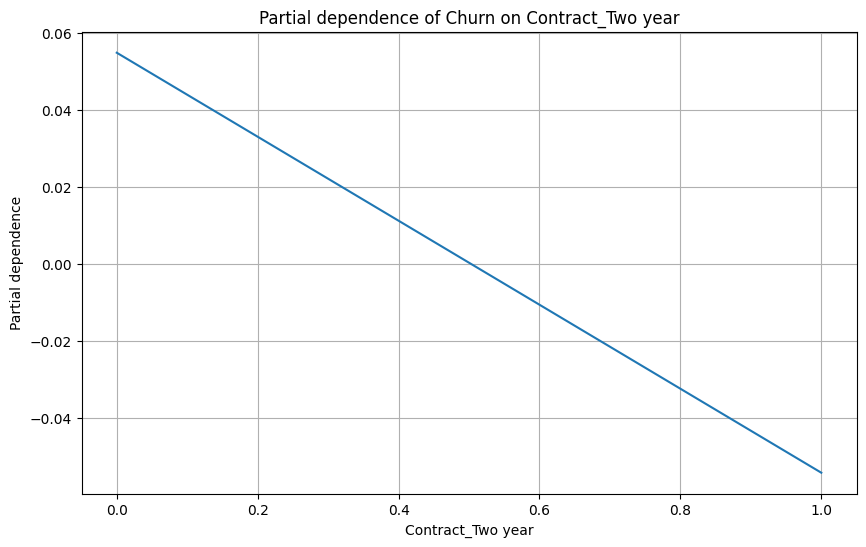

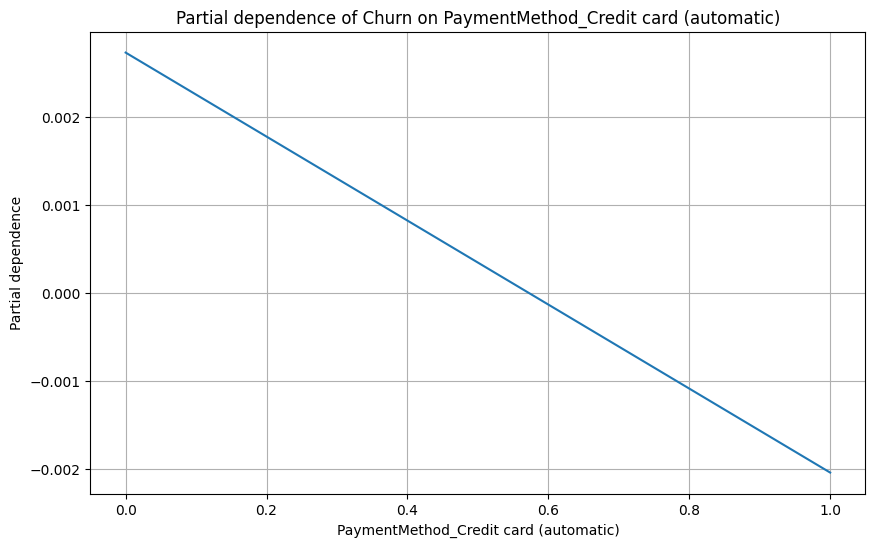

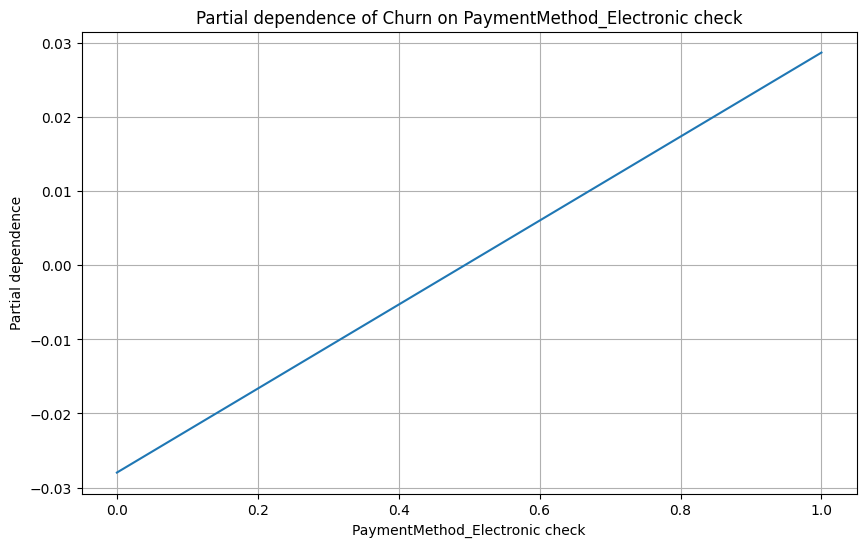

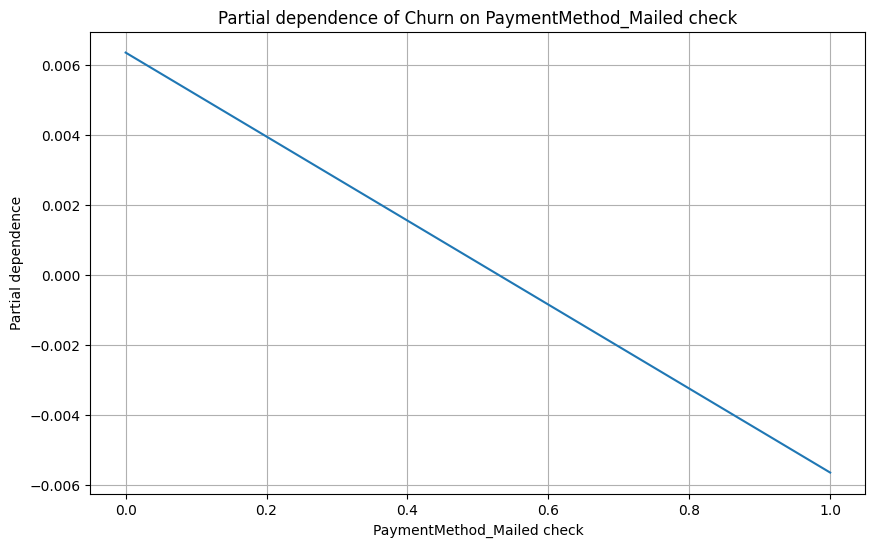

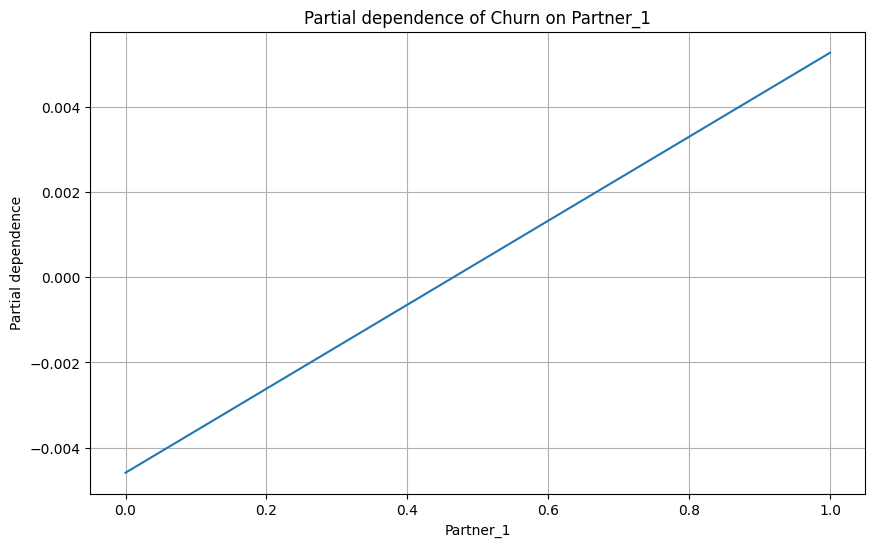

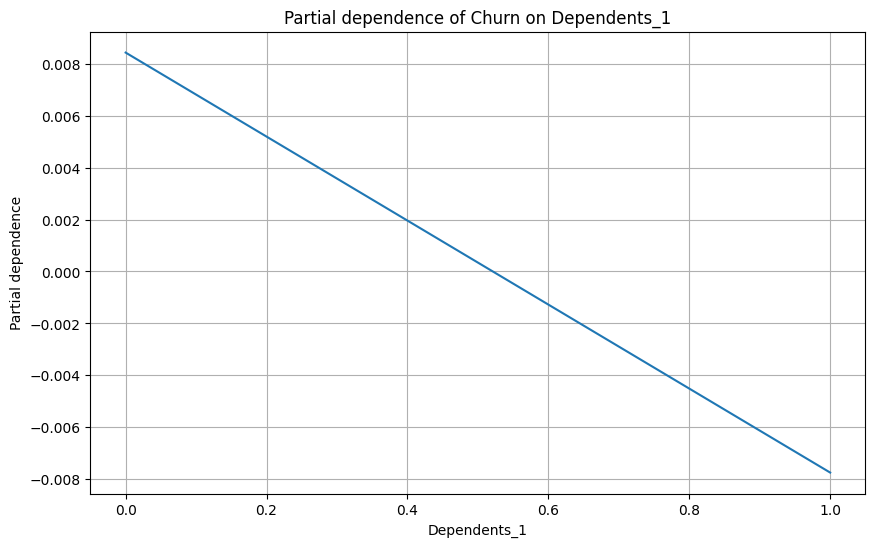

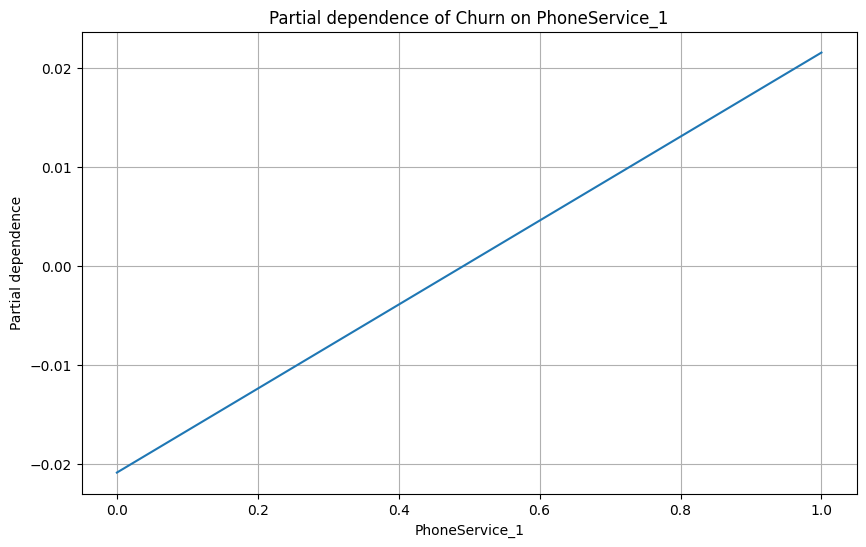

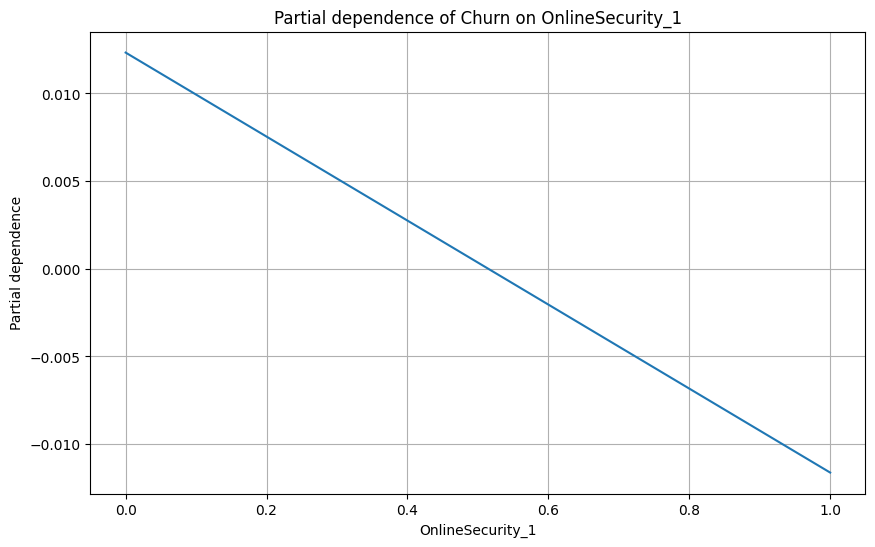

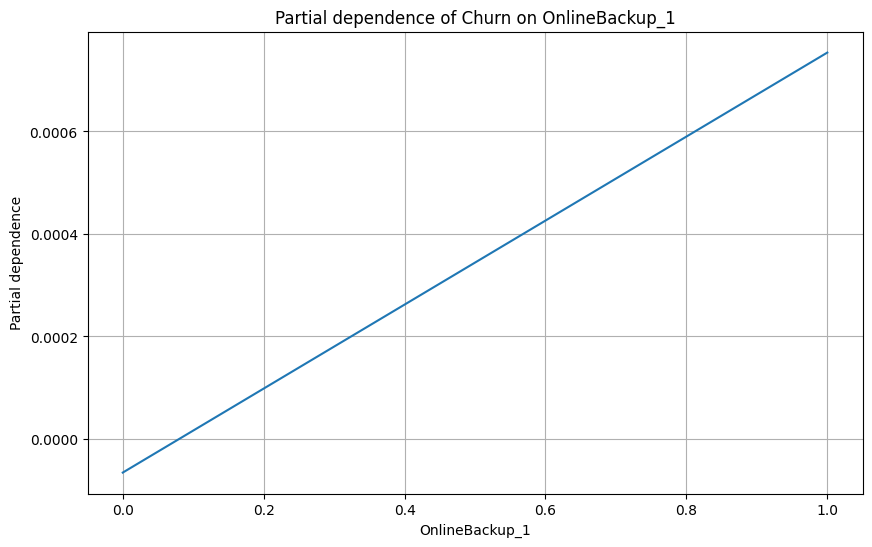

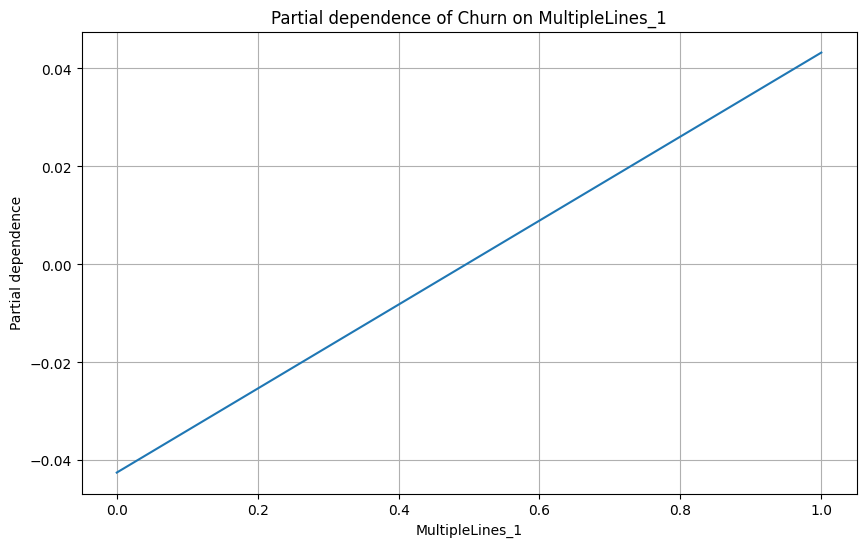

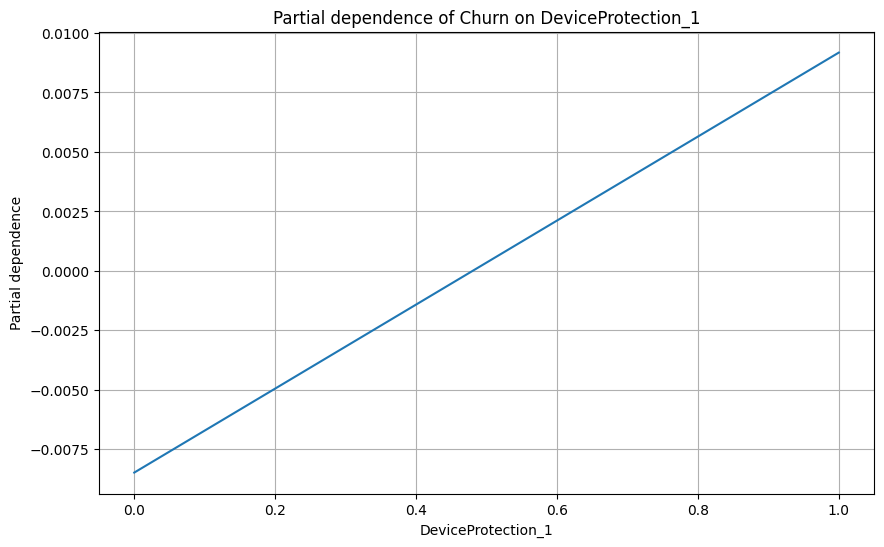

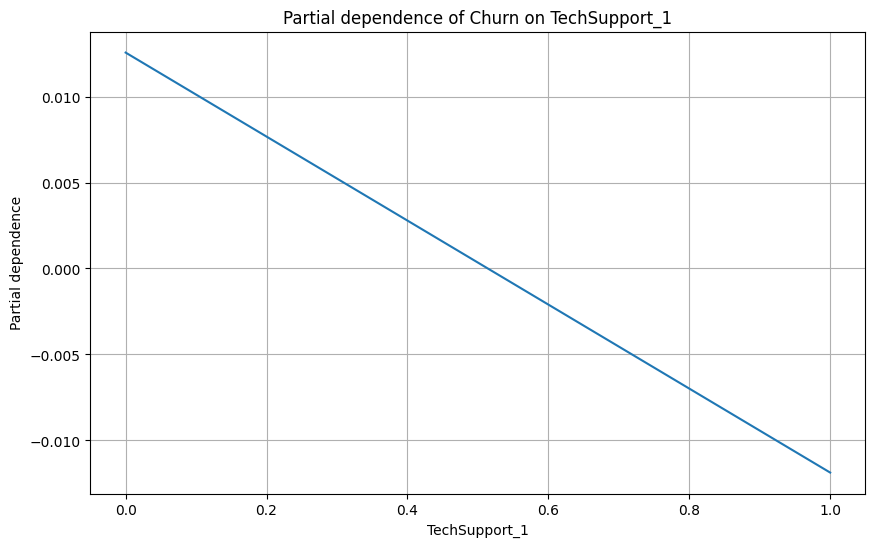

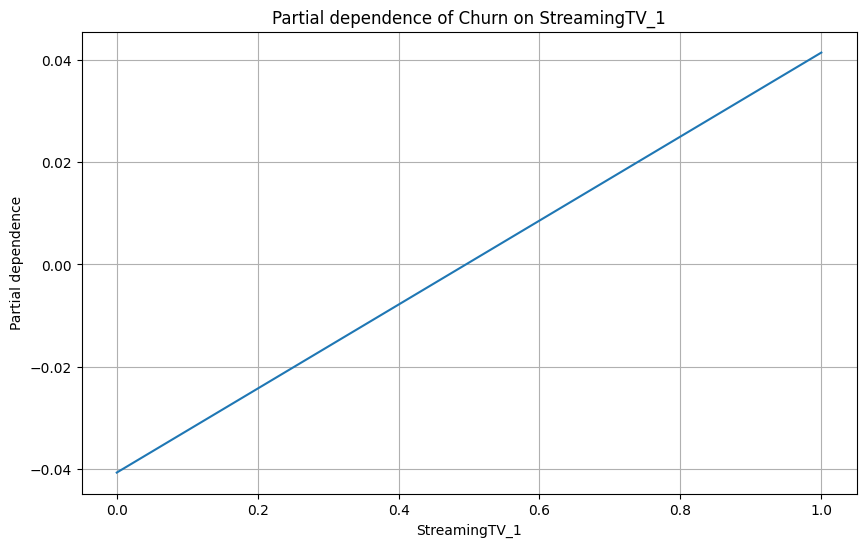

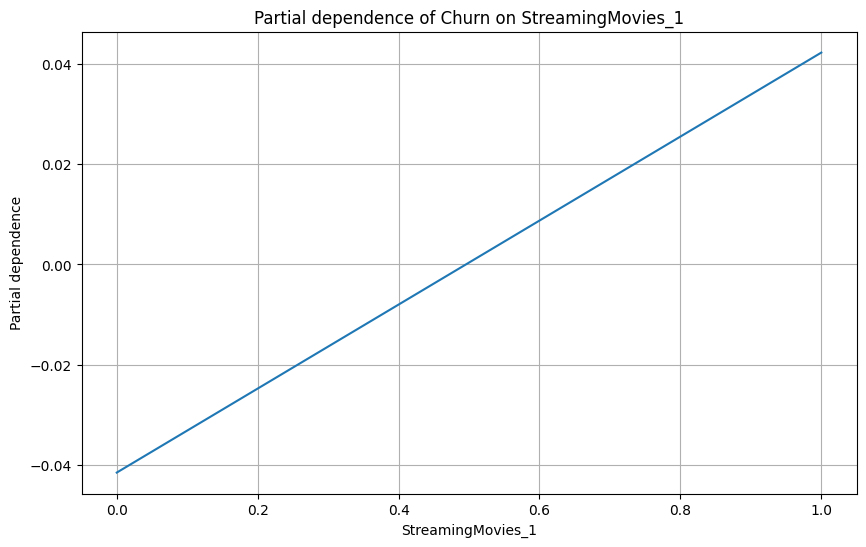

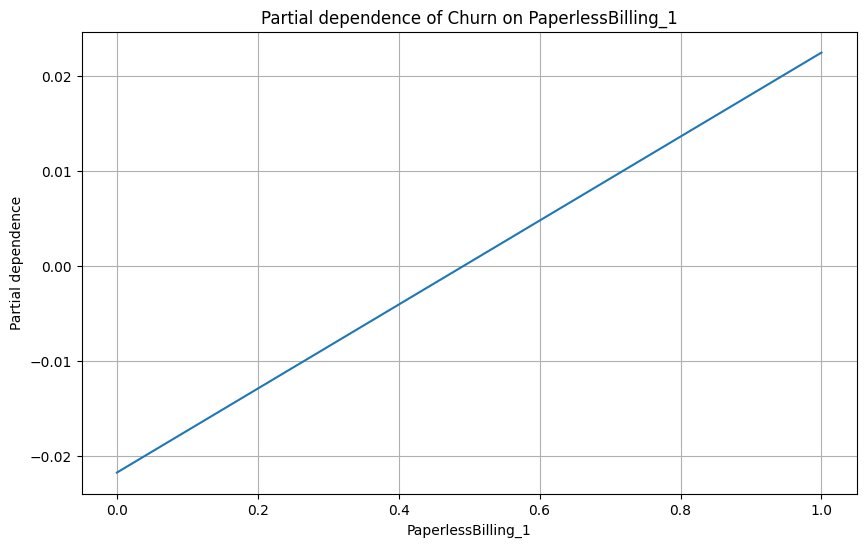

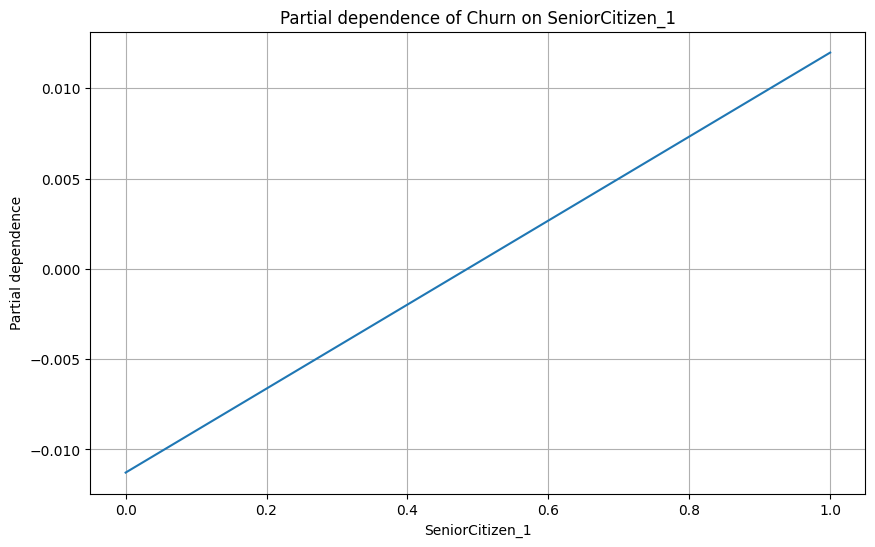

In [33]:
for i, col in enumerate(X_encoded.columns):
    XX = gam.generate_X_grid(i)
    partial_dep = gam.partial_dependence(i, X=XX)
    plt.figure(figsize=(10, 6))
    plt.plot(XX[:, i], partial_dep)
    plt.title(f'Partial dependence of Churn on {col}')
    plt.xlabel(col)
    plt.ylabel('Partial dependence')
    plt.grid(True)
    plt.show()

The trends are mostly linear. However, tenure, monthly charges, and total charges are shown to have non-linear patterns.

2. independence of errors

Analyze the residuals to check for independence of errors.


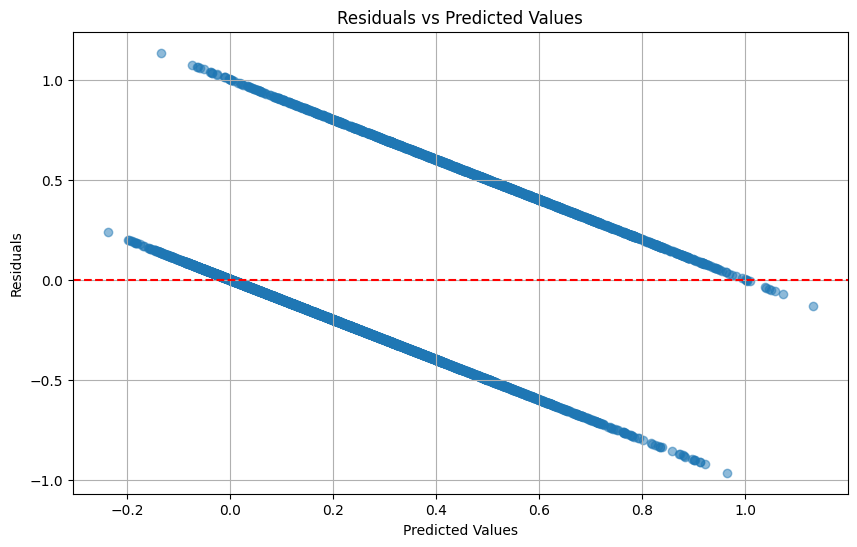

<Figure size 1000x600 with 0 Axes>

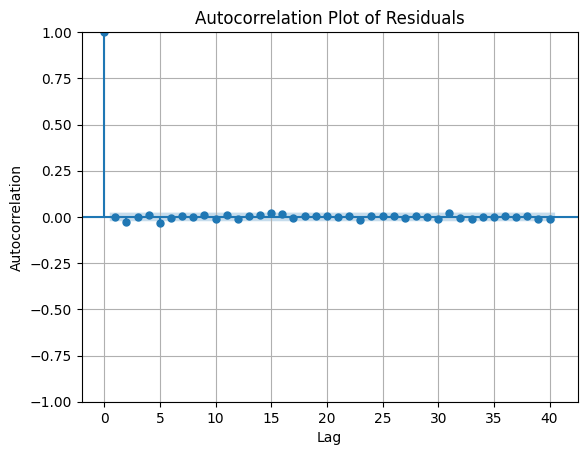

In [34]:
import statsmodels.api as sm

# Calculate predicted values
y_pred = gam.predict(X_encoded)

# Calculate residuals
residuals = y - y_pred

# Create scatter plot of residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# Create an autocorrelation plot of the residuals
plt.figure(figsize=(10, 6))
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('Autocorrelation Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

The errors seem to be independent.
From the residuals versus actual values plot, there isn't a clear pattern, even though there are 2 bands visible, but more likely showing the binary nature of Churn.
  
From the autocorrelation plot, the lags are very close to 0 and center within the blue region.

3. Normally Distributed Errors

Assess the distribution of errors to see if they follow a normal distribution.


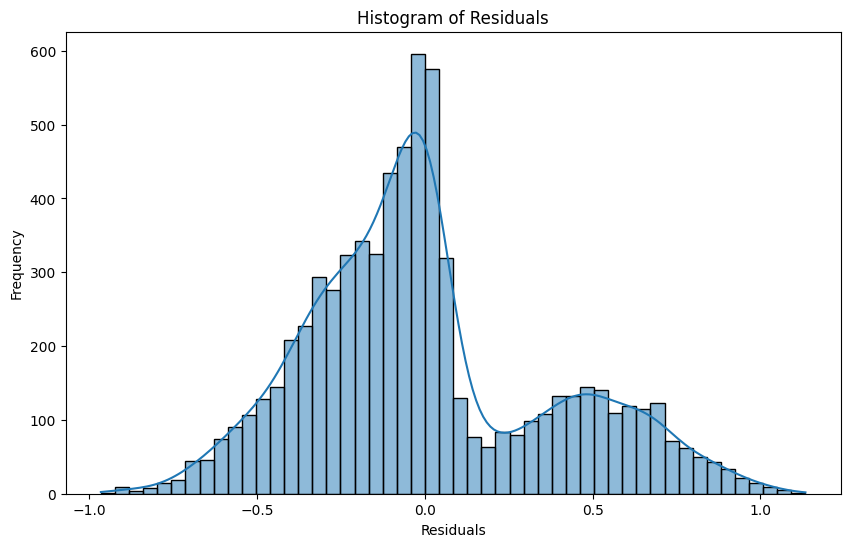

<Figure size 1000x600 with 0 Axes>

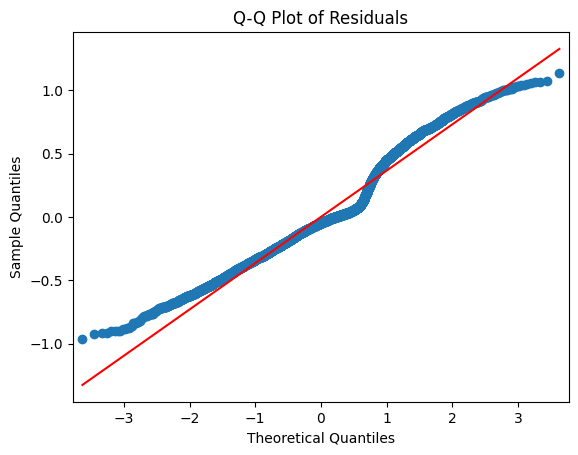

Shapiro-Wilk Test: Statistic=0.9602, P-value=0.0000
The residuals do not appear to be normally distributed (reject H0).


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7043.
  res = hypotest_fun_out(*samples, **kwds)


In [29]:
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic:.4f}, P-value={shapiro_test.pvalue:.4f}")

if shapiro_test.pvalue > 0.05:
    print("The residuals appear to be normally distributed (fail to reject H0).")
else:
    print("The residuals do not appear to be normally distributed (reject H0).")

The residuals are not normally distributed. This is the one violation of the assumptions for the linear GAM.

## 2 Linear Regression

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 0, test_size=0.25)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
resid = y_pred - y_test

In [36]:
print(f"The MSE score is {mean_squared_error(y_test, y_pred)}. The MAE score is {mean_absolute_error(y_test, y_pred)} and R^2 score is {r2_score(y_test, y_pred)}")

The MSE score is 0.14639092176743454. The MAE score is 0.3014003671125144 and R^2 score is 0.2445996637086656


The performance of the model shows a MSE score of 0.146. MAE score is 0.3. I would say the model perfomrance from the MSE is not bad, but as previously discussed, the linear regression would not be a good model here. The R^2 shows that only 24.4% of variance in Churn is explained by the predictors.  

In [39]:
# Display the coefficients
print("Linear Regression Coefficients:")
for feature, coef in zip(X_encoded.columns, regr.coef_):
    print(f"{feature}: {coef:.4f}")

Linear Regression Coefficients:
tenure: -0.0481
MonthlyCharges: 0.0914
TotalCharges: -0.1049
gender_Male: -0.0108
SeniorCitizen_1: 0.0251
InternetService_Fiber optic: 0.1026
InternetService_No: -0.0646
Contract_One year: -0.1151
Contract_Two year: -0.0716
PaymentMethod_Credit card (automatic): -0.0136
PaymentMethod_Electronic check: 0.0746
PaymentMethod_Mailed check: -0.0033
Partner_1: 0.0029
Dependents_1: -0.0255
PhoneService_1: -0.0885
OnlineSecurity_1: -0.0580
OnlineBackup_1: -0.0473
MultipleLines_1: 0.0505
DeviceProtection_1: -0.0121
TechSupport_1: -0.0554
StreamingTV_1: 0.0278
StreamingMovies_1: 0.0086
PaperlessBilling_1: 0.0430
SeniorCitizen_1: 0.0251


The linear regression shows that:



1.   For each unit increase in tenure (e.g., one additional month), the  predicted probability of churn decreases by approximately 4.8% (or 0.0481), holding all other variables constant.
2.   For each unit increase in MonthlyCharges (e.g., one additional dollar), the predicted probability of churn increases by approximately 9.14% (or 0.0914), holding all other variables constant.
3.   For each unit increase in TotalCharges (e.g., one additional dollar), the predicted probability of churn decreases by approximately 10.49% (or 0.1049), suggesting customers with higher cumulative spending are less likely to churn.
4.   Male customers have a predicted probability of churn that is 1.08% lower (−0.0108) compared to female customers, all else being equal.
5.   Senior citizens (age 65+) have a predicted probability of churn that is 2.51% higher (0.0251) than non-senior citizens, holding other factors constant.
6.   Customers with Fiber optic internet service have a predicted probability of churn that is 10.26% higher (0.1026) compared to those with DSL (the reference category), all else held equal.
7.   Customers with no internet service have a predicted probability of churn that is 6.46% lower (−0.0646) than those with DSL, suggesting they may be more stable in terms of retention.
8.   Customers on a one-year contract have a predicted probability of churn that is 11.51% lower (−0.1151) compared to those on a month-to-month contract, indicating longer contracts reduce churn.
9.   Customers on a two-year contract have a predicted probability of churn that is 7.16% lower (−0.0716) compared to those on a month-to-month contract, again showing contract length helps retain customers.
10.  Customers who use credit card (automatic) as their payment method have a predicted probability of churn that is 1.36% lower (−0.0136) compared to those using electronic check (reference category).
11.  Customers who use electronic check for payments have a predicted probability of churn that is 7.46% higher (0.0746) compared to those using other methods (with electronic check as reference), suggesting this group is at higher risk of churning.
12.  Customers who pay via mailed check have a predicted probability of churn that is 0.33% lower (−0.0033) compared to those using electronic check, though this effect is very small.
13.  Customers with a partner have a predicted probability of churn that is 0.29% higher (0.0029) compared to those without a partner, though this effect is minimal.
14.  Customers with dependents have a predicted probability of churn that is 2.55% lower (−0.0255) than those without dependents, suggesting family ties may improve retention.
15.  Customers with phone service have a predicted probability of churn that is 8.85% lower (−0.0885) than those without, indicating phone service users may be more loyal.
16.  Customers with online security have a predicted probability of churn that is 5.80% lower (−0.0580), suggesting value-added services help reduce churn.
17.  Customers with online backup have a predicted probability of churn that is 4.73% lower (−0.0473), further supporting the idea that additional services improve retention.
18.  Customers with multiple phone lines have a predicted probability of churn that is 5.05% higher (0.0505), which may reflect complexity or dissatisfaction among this group.
19.  Customers with device protection have a predicted probability of churn that is 1.21% lower (−0.0121), indicating slight improvement in retention.
20.  Customers with tech support have a predicted probability of churn that is 5.54% lower (−0.0554), highlighting the importance of customer support in reducing churn.
21.  Customers who stream TV have a predicted probability of churn that is 2.78% higher (0.0278), possibly due to increased expectations or issues with streaming quality.
22.  Customers who stream movies have a predicted probability of churn that is 0.86% higher (0.0086), a small but positive association with churn.
23.  Customers with paperless billing have a predicted probability of churn that is 4.30% higher (0.0430), which may reflect a preference for modern, digital engagement — though it could also correlate with younger, less stable customers.




## 3. Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)

y_pred_proba = clf.predict_proba(X_test)[:, 1]  # probability of (Churn)
y_pred_class = clf.predict(X_test)              # predicted class (0 or 1)

In [41]:
classification_report_dict = classification_report(y_pred_class, y_test, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).T
display(classification_report_df)

,precision,recall,f1-score,support
0,0.892912,0.842297,0.866866,1376.000000
1,0.531317,0.638961,0.580189,385.000000
accuracy,0.797842,0.797842,0.797842,0.797842
macro avg,0.712115,0.740629,0.723527,1761.000000
weighted avg,0.813858,0.797842,0.804191,1761.000000


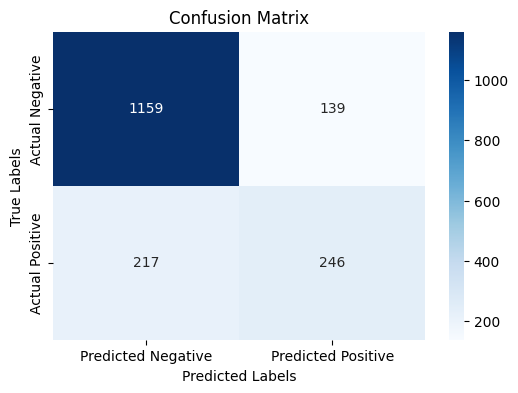

In [42]:
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [44]:
coefficients = clf.coef_[0]
odds_ratios = np.exp(coefficients)
change_odds_percent = (odds_ratios - 1) * 100

coef_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient (log-odds)': coefficients,
    'Odds Ratio': odds_ratios,
    'Change Odds by %': change_odds_percent
}).sort_values(by='Odds Ratio', key=lambda x: abs(x - 1), ascending=False)

In [45]:
coef_df

,Feature,Coefficient (log-odds),Odds Ratio,Change Odds by %
2,TotalCharges,0.621901,1.862466,86.246570
0,tenure,-1.411390,0.243804,-75.619575
8,Contract_Two year,-1.350272,0.259170,-74.083025
14,PhoneService_1,-0.899442,0.406797,-59.320329
1,MonthlyCharges,0.429626,1.536682,53.668207
7,Contract_One year,-0.755397,0.469824,-53.017618
5,InternetService_Fiber optic,0.402204,1.495116,49.511598
10,PaymentMethod_Electronic check,0.340824,1.406106,40.610567
22,PaperlessBilling_1,0.340703,1.405935,40.593531
15,OnlineSecurity_1,-0.451222,0.636849,-36.315053


The logistic regression shows the following impact of features on the odds of churn:

1.  **TotalCharges**: For a one-unit increase in TotalCharges, the odds of churn increase by approximately 86.25%.
2.  **tenure**: For a one-unit increase in tenure, the odds of churn decrease by approximately 75.62%.
3.  **Contract_Two year**: Having a two-year contract (compared to month-to-month) decreases the odds of churn by approximately 74.08%.
4.  **PhoneService_1**: Having phone service (compared to no phone service) decreases the odds of churn by approximately 59.32%.
5.  **MonthlyCharges**: For a one-unit increase in MonthlyCharges, the odds of churn increase by approximately 53.67%.
6.  **Contract_One year**: Having a one-year contract (compared to month-to-month) decreases the odds of churn by approximately 53.02%.
7.  **InternetService_Fiber optic**: Having Fiber optic internet service (compared to DSL) increases the odds of churn by approximately 49.51%.
8.  **PaymentMethod_Electronic check**: Using electronic check (compared to Bank transfer (automatic)) increases the odds of churn by approximately 40.61%.
9.  **PaperlessBilling_1**: Having paperless billing increases the odds of churn by approximately 40.59%.
10. **OnlineSecurity_1**: Having online security decreases the odds of churn by approximately 36.32%.
11. **MultipleLines_1**: Having multiple lines increases the odds of churn by approximately 32.98%.
12. **TechSupport_1**: Having tech support decreases the odds of churn by approximately 32.86%.
13. **InternetService_No**: Having no internet service (compared to DSL) decreases the odds of churn by approximately 29.40%.
14. **OnlineBackup_1**: Having online backup decreases the odds of churn by approximately 28.12%.
15. **Dependents_1**: Having dependents decreases the odds of churn by approximately 17.53%.
16. **PaymentMethod_Credit card (automatic)**: Using credit card (automatic) (compared to Bank transfer (automatic)) decreases the odds of churn by approximately 14.34%.
17. **SeniorCitizen_1**: Being a senior citizen increases the odds of churn by approximately 14.16%.
18. **StreamingTV_1**: Having streaming TV increases the odds of churn by approximately 11.60%.
19. **DeviceProtection_1**: Having device protection decreases the odds of churn by approximately 8.38%.
20. **gender_Male**: Being male (compared to female) decreases the odds of churn by approximately 7.97%.
21. **Partner_1**: Being a partner increases the odds of churn by approximately 2.91%.
22. **PaymentMethod_Mailed check**: Using mailed check (compared to Bank transfer (automatic)) decreases the odds of churn by approximately 2.86%.
23. **StreamingMovies_1**: Having streaming movies decreases the odds of churn by approximately 1.56%.

##4. GAM

In [46]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma
from statsmodels.genmod.families.links import Log
from statsmodels.tools import add_constant
from pygam import LinearGAM, GammaGAM, s

In [47]:
# Initilize GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9))

# Fit the model
gam.fit(X_train, y_train)

# Make predictions
y_pred_gam = gam.predict(X_test)

# Calculate MSE and R^2
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam)

print(f"GAM MSE: {mse_gam:.4f}, R^2: {r2_gam:.4f}")

gam.summary()

GAM MSE: 0.1449, R^2: 0.2520
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     54.5826
Link Function:                     IdentityLink Log Likelihood:                                -13558.5695
Number of Samples:                         5282 AIC:                                            27228.3041
                                                AICc:                                           27229.5078
                                                GCV:                                                0.1383
                                                Scale:                                              0.1358
                                                Pseudo R-Squared:                                   0.3121
Feature 

/tmp/ipython-input-3769935866.py:16: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


From the summary table, there are some non-linear effects:

*   Non-linear effects: Features with EDoF significantly greater than 1 (e.g., s(0) (tenure), s(1) (MonthlyCharges), s(2) (TotalCharges) with EDoF > 15) show strong non-linearity.
*   Linear effects: Binary features like gender_Male, SeniorCitizen_1, etc, where the EDoF is close to 1, are modeled with a nearly linear relationship with the logit of churn.
*   Statistical significance: Nearly all features have very low p-values (e.g., < 0.001), suggesting their smoothing or linear terms are statistically significant. However, p-values for penalized GAMs can be lower than they should be, so these cannot be taken too seriously on their own.
*   Model fit: The Pseudo R^2 of 0.3121 indicates that the model explains about 31.2% of the variance in churn. Although it is better than the linear model, it suggests moderate explanatory power. The AIC is 27228.3041 and GCV is 0.1383. These metrics are useful for comparing different GAM models.

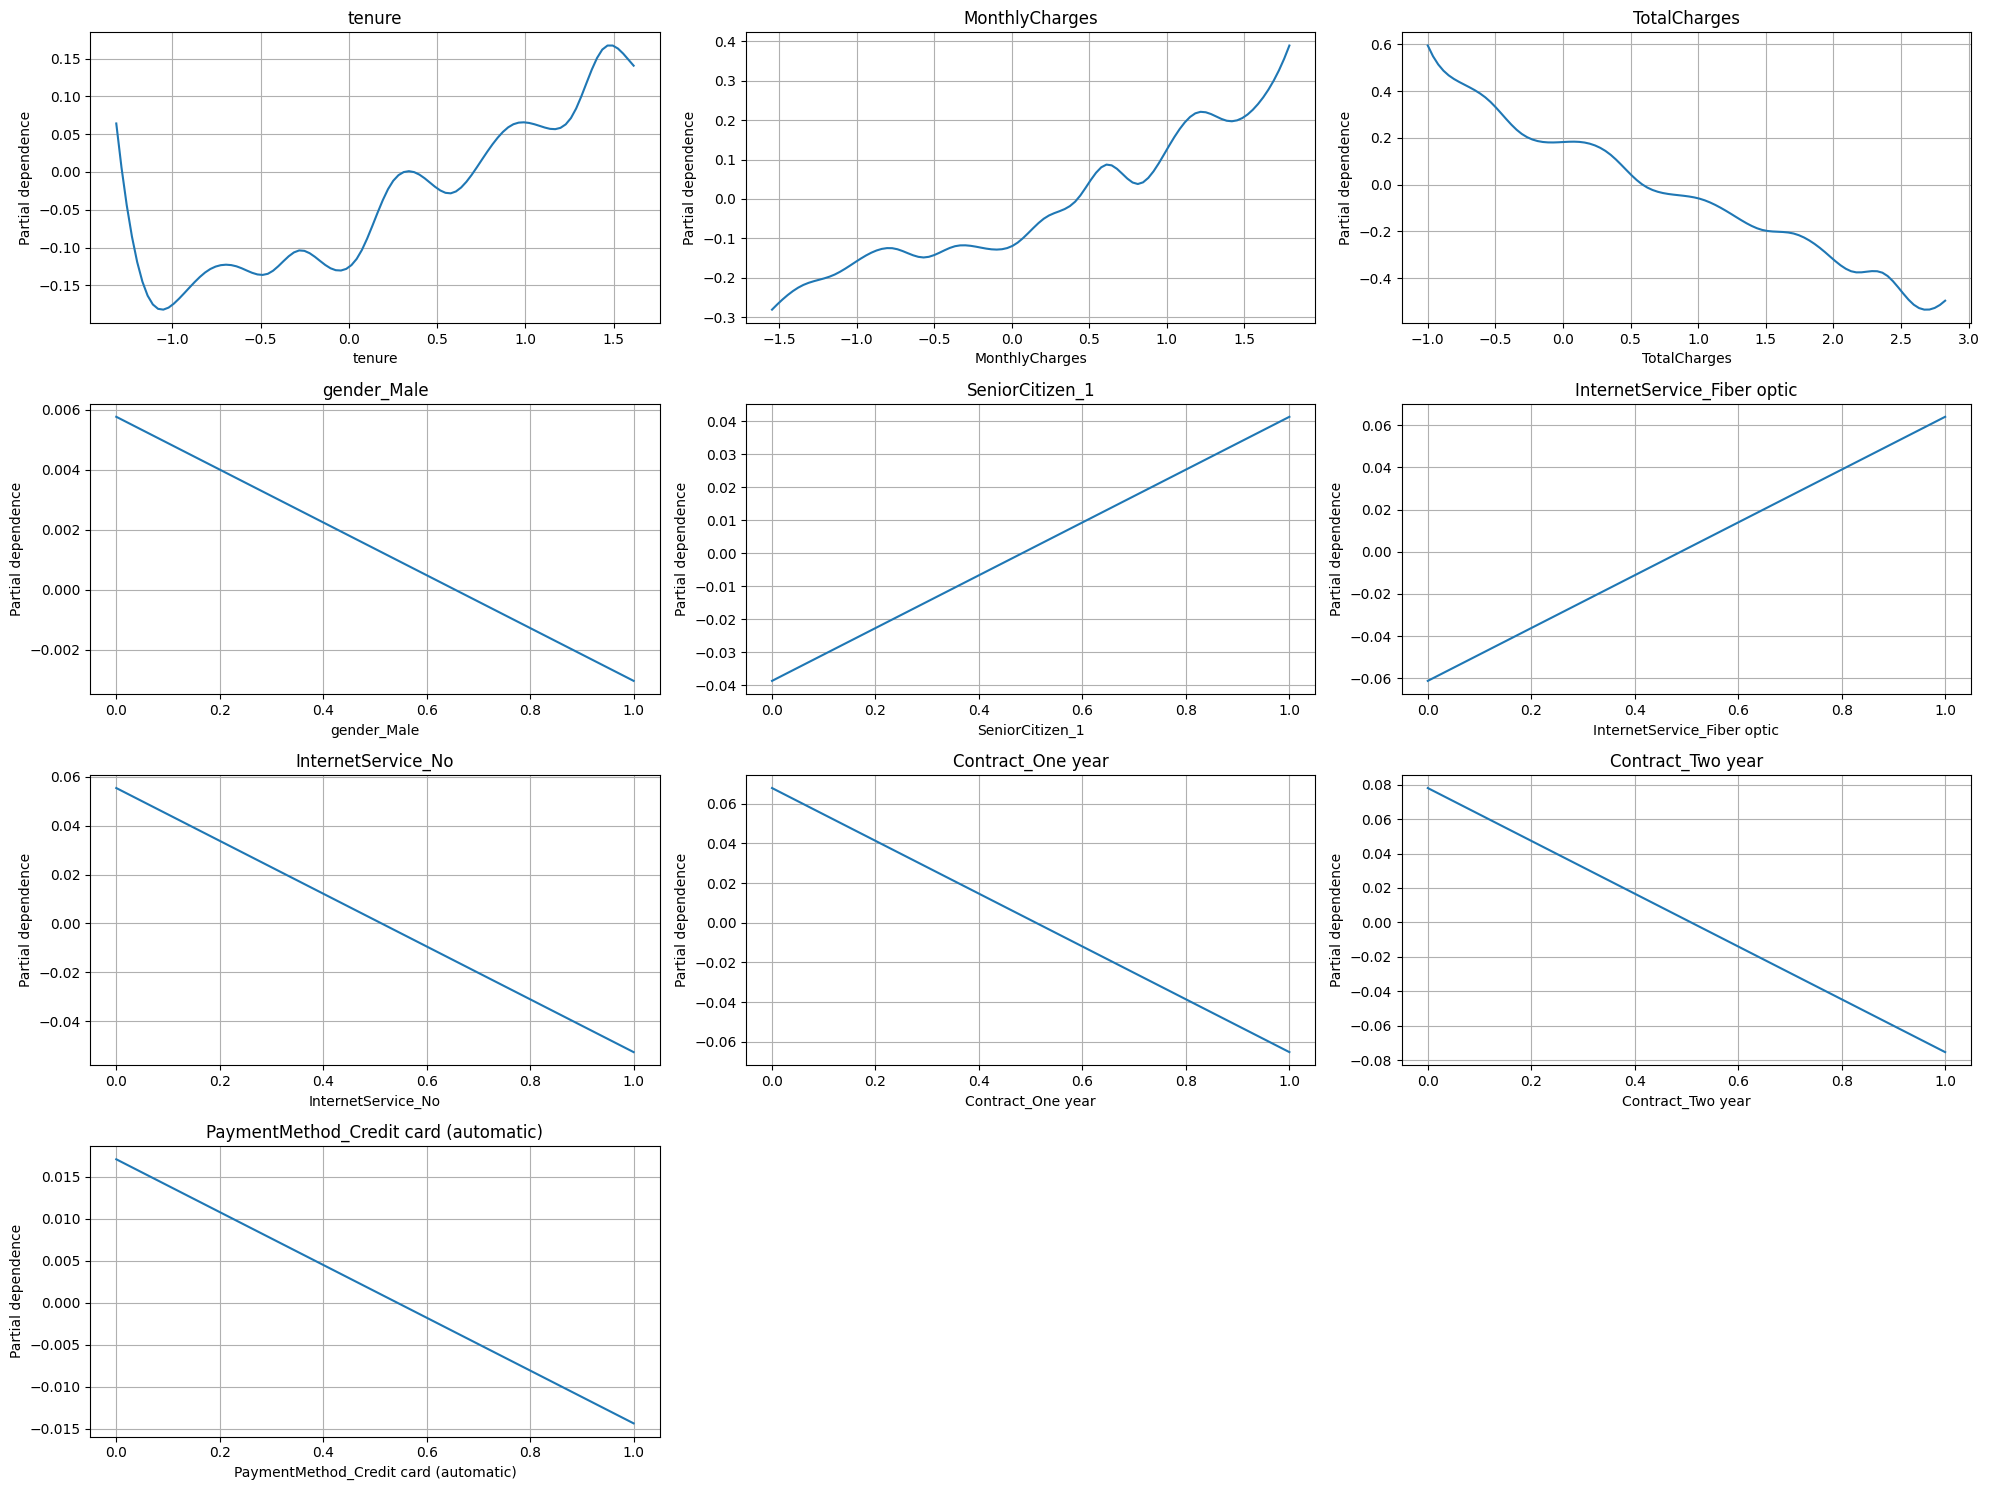

In [50]:
plt.figure(figsize=(20, 15))
feature_names = X_encoded.columns.tolist()

n_terms = len(gam.terms) - 1
n_cols = 3
n_rows = (n_terms + n_cols - 1) // n_cols

for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    subplot_idx = i + 1
    plt.subplot(n_rows, n_cols, subplot_idx)

    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX))

    plt.title(feature_names[term.feature])
    plt.ylabel('Partial dependence')
    plt.xlabel(feature_names[term.feature])
    plt.grid(True)

plt.tight_layout()
plt.show()

Partial dependence plots show how each feature affects predicted churn, averaging out other variables. For numeric features (tenure, MonthlyCharges, TotalCharges) curves show strong non-linear patterns: churn drops sharply early in tenure then stabilizes; rises with MonthlyCharges but unevenly; falls with TotalCharges.

For binary features, slope direction indicates effect: positive for SeniorCitizen_1 and InternetService_Fiber_optic (increase churn); negative for other features like Dependents, PhoneService, TechSupport, OnlineSecurity, etc. (reduce churn).

Plots validate both linear and non-linear relationships learned by the model.

## 4. Model Comparisons



* Linear Regression:
    *   The MSE score is 0.1464, the MAE score is 0.3014, and the R^2 score is 0.2446.
    *   Linear Regression is not ideal for a binary target variable like Churn. The R^2 indicates that only about 24.5% of the variance in Churn is explained by the predictors.

* Logistic Regression:
    *   The classification report shows an overall accuracy of 0.7978.
    *   The confusion matrix indicates that the model correctly predicts a good portion of both the 'No Churn' (True Negatives) and 'Yes Churn' (True Positives) cases, although there are still a number of False Positives and False Negatives.
    *   The precision, recall, and F1-score for the 'Yes' class (Churn = 1) are 0.5313, 0.6390, and 0.5802 respectively. This is a moderate performance in identifying actual churn cases.
    *   Logistic Regression is a more appropriate model for this binary classification problem compared to Linear Regression.

* GAM:
    *   The GAM achieved an MSE of 0.1449 and an R^2 of 0.2520 on the test set.
    *   The Pseudo R^2 from the summary table is 0.3121, indicating that the model explains about 31.2% of the variance in churn on the training data.
    *   The AIC is 27228.3041 and GCV is 0.1383. These values can be used for model comparison; lower AIC and GCV generally suggest a better fit while penalizing for model complexity.
    *   The GAM's ability to capture non-linear relationships makes it potentially more flexible than a standard linear or logistic regression model, especially for features like tenure, monthly charges, and total charges.


Based on the evaluation and assumption checks:

Linear Regression is not a suitable model due to the binary nature of the target variable churn, non-normal residuals, and relatively low R^2.

Logistic Regression is a more suitable  model for this binary classification task and shows reasonable performance metrics. It provides interpretable odds ratios for understanding feature impact.

GAM offers the flexibility to capture non-linear relationships and shows a slightly better Pseudo R^2 than the linear model. While the residuals are not normally distributed (a violation for a linear GAM), the independence assumption seems reasonably met. For churn, using a GammaGAM with a logit link may be a more statistically sound approach than LinearGAM.